<a href="https://colab.research.google.com/github/ucfilho/AI/blob/main/AI_2023/CV_CNN/class_007_image_processing_blood_cells_learning_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, ZeroPadding2D, MaxPool2D, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import cv2
import numpy as np

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

import zipfile
import pandas as pd


from sklearn.metrics import classification_report, confusion_matrix

In [3]:
IMAGE_SIZE = [224,224]
ImgSize = IMAGE_SIZE[0]
epochs = 16
batch_size = 128

In [4]:
!gdown 1CU4UkqJae07u1tKfp2rajWwwZA0SKiIm

Downloading...
From: https://drive.google.com/uc?id=1CU4UkqJae07u1tKfp2rajWwwZA0SKiIm
To: /content/blood_cell_images.zip
100% 110M/110M [00:02<00:00, 41.8MB/s]


In [5]:
FILE='blood_cell_images.zip'

In [6]:
archive = zipfile.ZipFile(FILE, 'r')
archive.extractall()

In [7]:
!ls

blood_cell_images  blood_cell_images.zip  __MACOSX  sample_data


In [8]:
train_path = 'blood_cell_images/TRAIN'
test_path = 'blood_cell_images/TEST'
images_test = glob(test_path + '/*/*.jp*g')
images_train = glob(train_path + '/*/*.jp*g')

In [9]:
folders_train = glob(train_path + '/*')
folders_test = glob(test_path + '/*')

In [10]:
folders_train

['blood_cell_images/TRAIN/LYMPHOCYTE',
 'blood_cell_images/TRAIN/NEUTROPHIL',
 'blood_cell_images/TRAIN/EOSINOPHIL',
 'blood_cell_images/TRAIN/MONOCYTE']

In [11]:
folders_test

['blood_cell_images/TEST/LYMPHOCYTE',
 'blood_cell_images/TEST/NEUTROPHIL',
 'blood_cell_images/TEST/EOSINOPHIL',
 'blood_cell_images/TEST/MONOCYTE']

In [12]:
ntrain, ntest = len(images_train),len(images_test)
ntrain,ntest

(9957, 2487)

In [13]:
images_train[:4]

['blood_cell_images/TRAIN/LYMPHOCYTE/_5_4023.jpeg',
 'blood_cell_images/TRAIN/LYMPHOCYTE/_8_4259.jpeg',
 'blood_cell_images/TRAIN/LYMPHOCYTE/_9_5850.jpeg',
 'blood_cell_images/TRAIN/LYMPHOCYTE/_20_6914.jpeg']

In [14]:
types = ['NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE']

In [15]:

def load_images(images,types=types):

  nsize = len(images)
  X =[]
  y =[]
  names =[]
  k = 0

  for i in range(nsize): 
    img = image.load_img(images[i])
    im = cv2.resize(np.array(img), (224, 224))
    im = preprocess_input(im)
    k += 1
    if( k % 3 == 0):
      X.append(im)

      if(types[0] in images[i]):
        names.append(types[0])
        y.append(0)
      elif(types[1] in images[i]):
        names.append(types[1])
        y.append(1)
      elif(types[2] in images[i]):
        names.append(types[2])
        y.append(2)
      else:
        names.append(types[3])
        y.append(3)

  X =np.array(X)
  return X,y,names

In [16]:

X_train, y_train, names_train = load_images(images_train)
X_test, y_test, names_test = load_images(images_test)

In [17]:
X_train[0].shape

(224, 224, 3)

In [18]:
df = pd.DataFrame({'name':names_train,'class':y_train})
y_train = pd.get_dummies(df['class'])
y_train

,0,1,2,3
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
3314,0,0,1,0
3315,0,0,1,0
3316,0,0,1,0
3317,0,0,1,0


In [19]:
for i in range(4): 
  df_plot= df[(df["class"] == i)]
  n= df_plot.shape[0]
  print(types[i],n)

NEUTROPHIL 833
EOSINOPHIL 833
MONOCYTE 826
LYMPHOCYTE 827


In [20]:
df = pd.DataFrame({'name':names_test,'class':y_test})
y_test = pd.get_dummies(df['class'])
y_test

,0,1,2,3
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
824,0,0,1,0
825,0,0,1,0
826,0,0,1,0
827,0,0,1,0


In [21]:
from keras.applications.mobilenet_v2 import MobileNetV2


In [22]:
D =len(types)
base_learning_rate = 0.0005
optimizer_base = 'rms'
fine_tune_at = 20
epochs_base = 30

def model(base_learning_rate, epochs_base,optimizer_base, fine_tune_at = fine_tune_at ):

  model = MobileNetV2(weights='imagenet')
  model_output = Dense(D, activation= 'softmax') #'relu')
  model_output = model_output(model.layers[-2].output)
  model_input = model.input
  model_new = Model(inputs=model_input, outputs=model_output)

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in model.layers[:fine_tune_at]:
    layer.trainable = False  

  if optimizer_base == 'adam':
    model_new.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
  elif optimizer_base == 'rms':
    model_new.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
  else:
    pass
  r = model_new.fit(
      x=X_train,
      y=y_train,
      validation_data=(X_test, y_test),
      epochs=epochs_base,
      verbose=0
  )
  return r


In [23]:
r  = model(base_learning_rate, epochs_base,optimizer_base)

14536120/14536120 [==============================] - 2s 0us/step


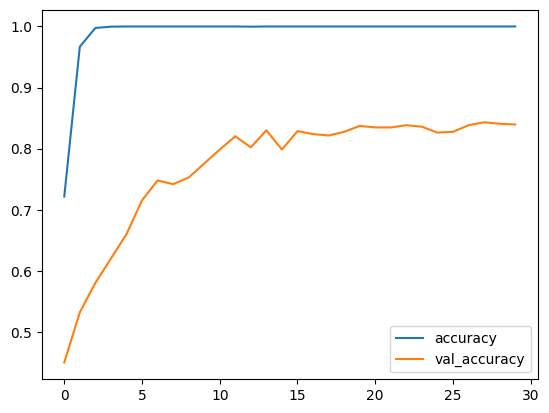

In [24]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

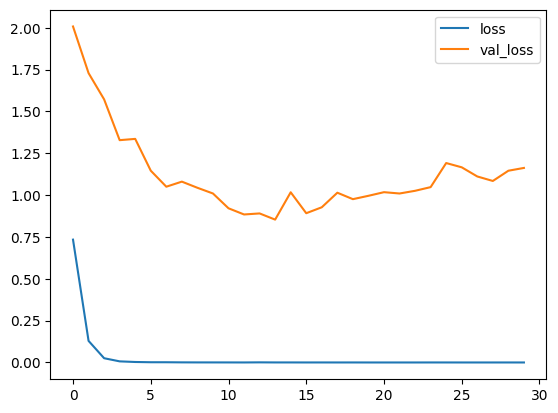

In [25]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [26]:
epochs_base = 15
model = MobileNetV2(weights='imagenet')
model_output = Dense(D, activation= 'softmax') #'relu')
model_output = model_output(model.layers[-2].output)
model_input = model.input
model_new = Model(inputs=model_input, outputs=model_output)
model_new.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
r = model_new.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=epochs_base,
    verbose=0
)

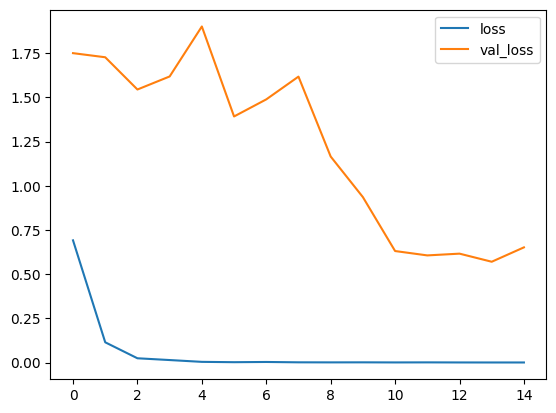

In [27]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

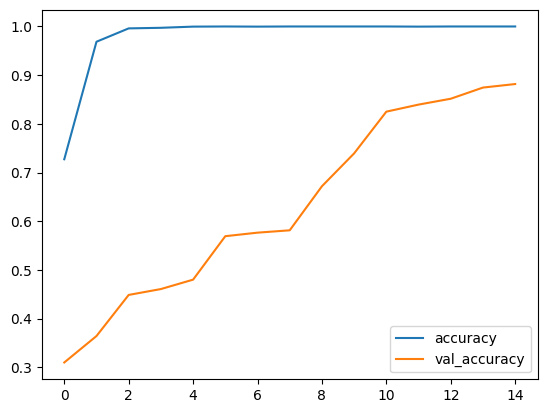

In [28]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [29]:
_, accuracy_test = model_new.evaluate(X_test,y_test)
print('accuracy test:',accuracy_test)

26/26 [==============================] - 1s 43ms/step - loss: 0.6514 - accuracy: 0.8818
accuracy test: 0.8817852735519409


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
def retorna(y):
  resp = []
  for yi in y:
    vmax =max(yi)
    for idx, x in enumerate(yi):
      if(x == vmax):
        resp.append(idx)
  return resp

In [32]:
predict=model_new.predict(X_test)

26/26 [==============================] - 2s 38ms/step


In [33]:
predict[0].shape

(4,)

In [34]:
y_calc = retorna(predict)
y_test = retorna(np.array(y_test))

In [35]:
confusion_matrix(y_test, y_calc)

array([[173,  28,   5,   2],
       [ 29, 174,   0,   5],
       [  4,  24, 178,   1],
       [  0,   0,   0, 206]])

In [36]:
# Classification Report
print('\n\n', classification_report(y_test, y_calc, target_names=types))



               precision    recall  f1-score   support

  NEUTROPHIL       0.84      0.83      0.84       208
  EOSINOPHIL       0.77      0.84      0.80       208
    MONOCYTE       0.97      0.86      0.91       207
  LYMPHOCYTE       0.96      1.00      0.98       206

    accuracy                           0.88       829
   macro avg       0.89      0.88      0.88       829
weighted avg       0.89      0.88      0.88       829

